In [1]:
import warnings
warnings.filterwarnings('ignore')

### Analyzing campaigns

textbook from [course](https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

marketing = pd.read_csv('marketing.csv', 
            parse_dates=['date_served', 'date_subscribed', 'date_canceled'])

marketing['DoW'] = marketing.date_subscribed.dt.dayofweek
marketing['is_retained'] = marketing['is_retained'].astype('bool')
marketing['converted'] = marketing['converted'].astype('bool')

marketing['is_correct_lang'] = np.where(marketing.language_displayed == 
                                   marketing.language_preferred, True, False)

In [3]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 14 columns):
user_id                10037 non-null object
date_served            10021 non-null datetime64[ns]
marketing_channel      10022 non-null object
variant                10037 non-null object
converted              10037 non-null bool
language_displayed     10037 non-null object
language_preferred     10037 non-null object
age_group              10037 non-null object
date_subscribed        1856 non-null datetime64[ns]
date_canceled          577 non-null datetime64[ns]
subscribing_channel    1856 non-null object
is_retained            10037 non-null bool
DoW                    1856 non-null float64
is_correct_lang        10037 non-null bool
dtypes: bool(3), datetime64[ns](3), float64(1), object(7)
memory usage: 892.1+ KB


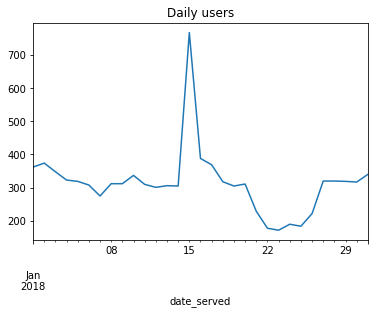

In [4]:
daily_users = marketing.groupby(['date_served'])['user_id'].nunique()
daily_users.plot(title='Daily users');

Common metrics of measuring campaign's success:<br>
- conversion rate (how many subscribed?)<br>
- retetntion rate (how many stayed?)

In [5]:
total = marketing.user_id.nunique()
subscribers = marketing[marketing.converted].user_id.nunique()
conversion_rate = subscribers / total
print('Conversion rate', round(conversion_rate*100, 2), "%")

retained = marketing[marketing.is_retained & marketing.converted].user_id.nunique()
retention_rate = retained / subscribers
print('Retention rate', round(retention_rate*100, 2), "%")

Conversion rate 14.09 %
Retention rate 67.57 %


### Customer segmentation

textbook from [course](https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas)

In [6]:
subscribed = marketing[marketing.converted].groupby('subscribing_channel').\
        user_id.nunique()
retained = marketing[marketing.is_retained].groupby('subscribing_channel').\
        user_id.nunique()
retention_rate = (retained / subscribed) * 100
print('Retention rate by channel\n\n', round(retention_rate, 2))

Retention rate by channel

 subscribing_channel
Email        87.58
Facebook     68.78
House Ads    58.05
Instagram    68.10
Push         70.13
Name: user_id, dtype: float64


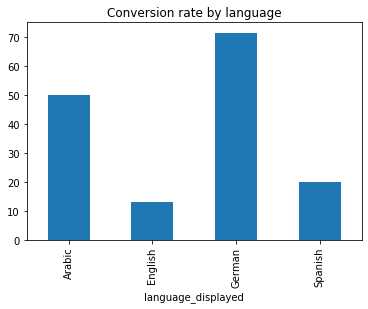

In [7]:
total = marketing.groupby('language_displayed').user_id.nunique()
subscribers = marketing[marketing.converted].groupby('language_displayed').\
        user_id.nunique()
language_conversion_rate = subscribers / total *100
language_conversion_rate.plot(kind='bar', title='Conversion rate by language');

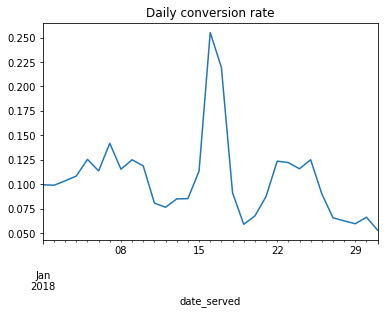

In [8]:
total = marketing.groupby('date_served').user_id.nunique()
subscribers = marketing[marketing.converted].groupby('date_served')\
        .user_id.nunique()
daily_conversion_rate = subscribers/total
daily_conversion_rate.plot(title='Daily conversion rate');

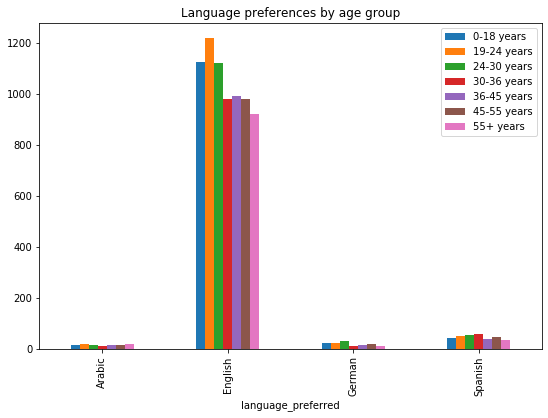

In [9]:
lang_age = marketing.groupby(['language_preferred', 'age_group']).\
        user_id.nunique()
lang_age = pd.DataFrame(lang_age.unstack(level=1))
lang_age.plot(kind='bar', title='Language preferences by age group', 
              figsize=(9,6))
plt.legend(loc='upper right', 
          labels=lang_age.columns.values);

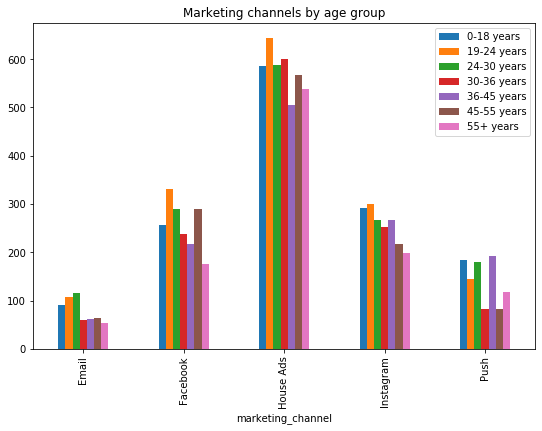

In [10]:
channel_age = marketing.groupby(['marketing_channel', 'age_group'])\
                                ['user_id'].nunique()
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))
channel_age_df.plot(kind = 'bar', title='Marketing channels by age group',
                    figsize=(9,6))
plt.legend(loc = 'upper right', 
           labels = channel_age_df.columns.values);

In [11]:
def conversion_rate(dataframe, column_names):
    column_conv = dataframe[dataframe['converted']].\
            groupby(column_names).user_id.nunique()
    column_total = dataframe.groupby(column_names).user_id.nunique() 
    conversion_rate = column_conv/column_total
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate

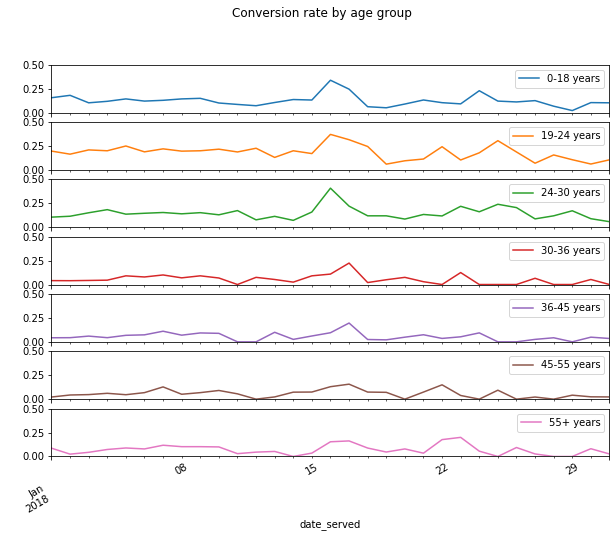

In [12]:
age_group_conv = conversion_rate(marketing, ['date_served', 'age_group'])
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))
age_group_df.plot(title='Conversion rate by age group', figsize=(10,8), 
                  subplots=True, ylim=(0,0.5));

### A/B testing

textbook from [course](https://www.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas)

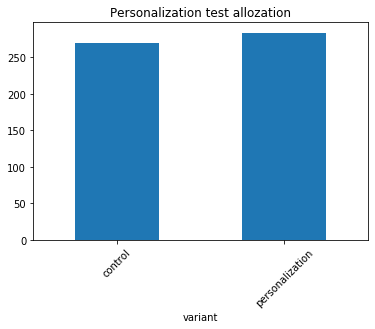

In [13]:
email = marketing[marketing.marketing_channel == 'Email']
allocation = email.groupby('variant').user_id.nunique()
allocation.plot(kind='bar', title='Personalization test allozation')
plt.xticks(rotation=45);

In [14]:
subscribers = email.groupby(['user_id','variant']).converted.max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

control = subscribers_df.control.dropna()
personalization = subscribers_df.personalization.dropna()
print('Control conversion rate:', control.mean())
print('Personalization conversion rate:', personalization.mean())

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


In [15]:
# lift
def lift(a,b):
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    lift = (b_mean-a_mean)/a_mean
    return str(round(lift*100, 2)) + '%'
  
print('lift:', lift(control, personalization))

lift: 38.85%


In [16]:
from scipy.stats import ttest_ind
t = ttest_ind(control, personalization)
print(t)
print('\nStatistically', 'significant' if t[1]<0.05 else 'unsignificant')

Ttest_indResult(statistic=-2.7343299447505074, pvalue=0.0064514878446941745)

Statistically significant


In [17]:
def ab_segmentation(segment):
  for subsegment in np.unique(marketing[segment].values):
      print(subsegment)
       
      email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna()
      personalization = subscribers['personalization'].dropna()

      print('lift:', lift(control, personalization))
      t = ttest_ind(control, personalization)
      print(t)
      print('Statistically', 'significant\n' if t[1]<0.05 else 'unsignificant\n')

In [18]:
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001)
Statistically unsignificant

English
lift: 39.0%
Ttest_indResult(statistic=-2.2183598646203166, pvalue=0.026991701290720815)
Statistically significant

German
lift: -1.62%
Ttest_indResult(statistic=0.1910083418078718, pvalue=0.8494394170062678)
Statistically unsignificant

Spanish
lift: 166.67%
Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524)
Statistically significant



In [19]:
ab_segmentation('age_group')

0-18 years
lift: 121.4%
Ttest_indResult(statistic=-2.966044912142211, pvalue=0.0038724494391297226)
Statistically significant

19-24 years
lift: 106.24%
Ttest_indResult(statistic=-3.03179438478667, pvalue=0.0030623836114689134)
Statistically significant

24-30 years
lift: 161.19%
Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867335)
Statistically significant

30-36 years
lift: -100.0%
Ttest_indResult(statistic=3.1859064644147996, pvalue=0.0023238487431765137)
Statistically significant

36-45 years
lift: -85.23%
Ttest_indResult(statistic=2.4317901279318503, pvalue=0.017975686009788286)
Statistically significant

45-55 years
lift: -72.22%
Ttest_indResult(statistic=2.065499127317933, pvalue=0.043062339688201196)
Statistically significant

55+ years
lift: -100.0%
Ttest_indResult(statistic=3.3265654564203397, pvalue=0.0016358623456360435)
Statistically significant



# Churn, CLV, purchase prediction, customer segmentation

textbook from [course](https://www.datacamp.com/courses/machine-learning-for-marketing-in-python)

## Churn prediction

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

telco_raw = pd.read_csv('telco.csv')

In [21]:
telco_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [22]:
telco_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [23]:
custid = ['customerID']
target = ['Churn']

# Store categorical column names
categorical = telco_raw.nunique()[telco_raw.nunique() < 5].keys().tolist()

# Remove target from the list of categorical variables
categorical.remove(target[0])

# Store numerical column names
numerical = [x for x in telco_raw.columns if x 
             not in custid + target + categorical]

In [24]:
from sklearn.preprocessing import StandardScaler
# Perform one-hot encoding to categorical variables 
telco_raw = pd.get_dummies(data = telco_raw, columns = categorical, drop_first=True)

# Initialize StandardScaler instance
scaler = StandardScaler()

# Fit and transform the scaler on numerical columns
telco_raw = telco_raw[telco_raw['TotalCharges'] != ' ']
for col in numerical: telco_raw[col] = pd.to_numeric(telco_raw[col])
scaled_numerical = scaler.fit_transform(telco_raw[numerical])

# Build a DataFrame from scaled_numerical
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)

telco_raw[numerical] = scaled_numerical
cols = [x for x in telco_raw.columns if x 
             not in custid + target]
telco_raw.dropna(axis=0, how='any', inplace=True)

y = telco_raw[target]
X = telco_raw[cols]

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25)

In [26]:
telco_raw.groupby(target).size() / telco_raw.shape[0] * 100

Churn
No     73.422589
Yes    26.577411
dtype: float64

### Churn Prediction using Logistic Regression

In [27]:
def print_scores(train_y, test_y, pred_train_y, pred_test_y):
    print("Training accuracy: ", round(accuracy_score(train_y, pred_train_y), 3))
    print("Training precision: ", round(precision_score(train_y, pred_train_y, pos_label="Yes"), 3))
    print("Training recall: ", round(recall_score(train_y, pred_train_y, pos_label="Yes"), 3))
    print("\nTest accuracy: ", round(accuracy_score(test_y, pred_test_y), 3))
    print("Test precision: ", round(precision_score(test_y, pred_test_y, pos_label="Yes"), 3))
    print("Test recall: ", round(recall_score(test_y, pred_test_y, pos_label="Yes"), 3))

In [28]:
from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression(penalty='l1', C=0.025, solver='liblinear')
logreg1 = logreg1.fit(train_X, train_y.values.ravel())
pred_train_y = logreg1.predict(train_X)
pred_test_y = logreg1.predict(test_X)
print_scores(train_y, test_y, pred_train_y, pred_test_y)
print(confusion_matrix(test_y, pred_test_y))

Training accuracy:  0.781
Training precision:  0.629
Training recall:  0.419

Test accuracy:  0.782
Test precision:  0.643
Test recall:  0.437
[[1167  115]
 [ 267  207]]


In [29]:
C = [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025]
l1_metrics = np.zeros((len(C),5))
l1_metrics[:, 0] = C

for index in range(len(C)):
  # Initialize and fit Logistic Regression with the C candidate
  logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')
  logreg.fit(train_X, train_y.values.ravel())
  # Predict churn on the testing data
  pred_test_y = logreg.predict(test_X)
  # Create non-zero count and recall score columns
  l1_metrics[index,1] = np.count_nonzero(logreg.coef_)
  l1_metrics[index,2] = round(accuracy_score(test_y, pred_test_y), 3)
  l1_metrics[index,3] = round(precision_score(test_y, pred_test_y, pos_label="Yes"), 3)
  l1_metrics[index,4] = round(recall_score(test_y, pred_test_y, pos_label="Yes"), 3)

# Name the columns and print the array as pandas DataFrame
col_names = ['C','Non-Zero Coeffs', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(l1_metrics, columns=col_names))

        C  Non-Zero Coeffs  Accuracy  Precision  Recall
0  1.0000             26.0     0.786      0.631   0.504
1  0.5000             28.0     0.788      0.634   0.504
2  0.2500             27.0     0.789      0.637   0.506
3  0.1000             23.0     0.790      0.641   0.504
4  0.0500             22.0     0.790      0.649   0.487
5  0.0250             17.0     0.782      0.643   0.437
6  0.0100             14.0     0.760      0.663   0.228
7  0.0050              6.0     0.730      0.000   0.000
8  0.0025              0.0     0.730      0.000   0.000


In [30]:
coefficients = pd.concat([pd.DataFrame(train_X.columns),
                         pd.DataFrame(np.transpose(logreg1.coef_))], axis=1)
coefficients.columns = ['Feature', 'Coefficient']
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients[coefficients['Coefficient'] != 0]
coefficients.sort_values('Exp_Coefficient')

,Feature,Coefficient,Exp_Coefficient
25,Contract_Two year,-1.604662,0.200957
24,Contract_One year,-0.873621,0.417437
18,TechSupport_No internet service,-0.470753,0.624532
13,OnlineSecurity_Yes,-0.454616,0.634692
20,StreamingTV_No internet service,-0.379043,0.684516
19,TechSupport_Yes,-0.294178,0.745144
15,OnlineBackup_Yes,-0.174710,0.839700
5,Partner_Yes,-0.169582,0.844017
6,Dependents_Yes,-0.108687,0.897011
7,PhoneService_Yes,-0.097927,0.906715


### Churn Prediction using Decision Trees

In [31]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(train_X, train_y)
pred_train_y = clf.predict(train_X)
pred_test_y = clf.predict(test_X)
print_scores(train_y, test_y, pred_train_y, pred_test_y)

Training accuracy:  0.764
Training precision:  0.547
Training recall:  0.624

Test accuracy:  0.756
Test precision:  0.543
Test recall:  0.612


In [32]:
depth_list = list(range(2,15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list

for index in range(len(depth_list)):
  # Initialize and fit Logistic Regression with the C candidate
  mytree = tree.DecisionTreeClassifier(max_depth = depth_list[index])
  mytree = mytree.fit(train_X, train_y)
  # Predict churn on the testing data
  pred_test_y = mytree.predict(test_X)
  # Create non-zero count and recall score columns
  depth_tuning[index,1] = round(accuracy_score(test_y, pred_test_y), 3)
  depth_tuning[index,2] = round(precision_score(test_y, pred_test_y, pos_label="Yes"), 3)
  depth_tuning[index,3] = round(recall_score(test_y, pred_test_y, pos_label="Yes"), 3)

# Name the columns and print the array as pandas DataFrame
col_names = ['Max Depth', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))

    Max Depth  Accuracy  Precision  Recall
0         2.0     0.730      0.000   0.000
1         3.0     0.756      0.543   0.612
2         4.0     0.769      0.578   0.542
3         5.0     0.769      0.615   0.388
4         6.0     0.772      0.582   0.546
5         7.0     0.767      0.572   0.534
6         8.0     0.768      0.585   0.481
7         9.0     0.749      0.546   0.426
8        10.0     0.748      0.536   0.504
9        11.0     0.737      0.513   0.530
10       12.0     0.722      0.485   0.502
11       13.0     0.740      0.518   0.515
12       14.0     0.728      0.496   0.538


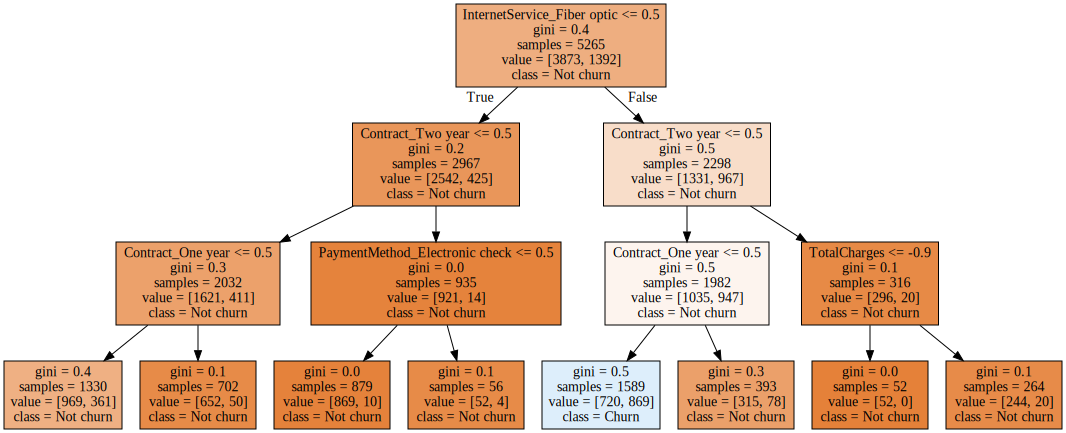

In [33]:
from sklearn import tree
import graphviz

exported = tree.export_graphviz(decision_tree = clf, out_file=None, feature_names=train_X.columns,
                              precision=1, class_names=['Not churn', 'Churn'], filled=True)
graph = graphviz.Source(exported)
display(graph)

## Customer Lifetime Value

CLV = (AverageRevenue * ProfitMargin) * $ \frac{Retention Rate}{Churn Rate} $ 

how to calculate retention & churn:

In [34]:
cohorts = pd.read_csv('cohorts.csv', index_col='AcquisitionMonth')

In [35]:
cohort_sizes = cohorts.iloc[:,0]
retention = cohorts.divide(cohort_sizes, axis=0)
churn = 1 - retention
retention

,1,2,3,4,5,6,7,8,9,10,11,12,13
AcquisitionMonth,,,,,,,,,,,,,
2010-12,1.0,0.343575,0.308659,0.350559,0.342179,0.398045,0.347765,0.329609,0.335196,0.370112,0.354749,0.486034,0.240223
2011-01,1.0,0.207831,0.246988,0.243976,0.331325,0.271084,0.246988,0.259036,0.313253,0.307229,0.373494,0.135542,NaN
2011-02,1.0,0.183544,0.180380,0.262658,0.268987,0.234177,0.253165,0.262658,0.272152,0.300633,0.088608,NaN,NaN
2011-03,1.0,0.162371,0.257732,0.195876,0.213918,0.172680,0.252577,0.219072,0.275773,0.097938,NaN,NaN,NaN
2011-04,1.0,0.192157,0.203922,0.192157,0.184314,0.203922,0.219608,0.231373,0.066667,NaN,NaN,NaN,NaN
2011-05,1.0,0.160643,0.172691,0.144578,0.208835,0.232932,0.244980,0.088353,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.159420,0.125604,0.198068,0.236715,0.299517,0.091787,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.161850,0.179191,0.219653,0.254335,0.098266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.215827,0.201439,0.251799,0.100719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
retention_rate = retention.iloc[:,1:].mean().mean()
churn_rate = churn.iloc[:,1:].mean().mean()
print('Retention rate: {:.2f}; Churn rate: {:.2f}'
      .format(retention_rate, churn_rate))

Retention rate: 0.24; Churn rate: 0.76


___CLV___

In [37]:
online = pd.read_csv('on2.csv', header=0, index_col='id', parse_dates=['InvoiceDate'])

In [38]:
online.head()

,InvoiceMonth,CustomerID,InvoiceDate,InvoiceNo,TotalSum,Quantity
id,,,,,,
416792,2011-10,14286.0,2011-10-25 08:26:00,572558,12.60,6
482904,2011-11,16360.0,2011-11-20 11:56:00,577485,1.45,1
263743,2011-07,13933.0,2011-07-14 13:35:00,560034,22.50,6
495549,2011-11,17290.0,2011-11-23 15:53:00,578307,2.10,1
204384,2011-05,17663.0,2011-05-25 13:36:00,554656,17.85,3


In [39]:
online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70864 entries, 416792 to 312243
Data columns (total 6 columns):
InvoiceMonth    70864 non-null object
CustomerID      70864 non-null float64
InvoiceDate     70864 non-null datetime64[ns]
InvoiceNo       70864 non-null int64
TotalSum        70864 non-null float64
Quantity        70864 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 3.8+ MB


In [40]:
monthly_revenue = online.groupby(['CustomerID', 'InvoiceMonth'])['TotalSum'].sum().mean()
monthly_revenue = np.mean(monthly_revenue)
print('Monthly revenue: {:.1f} USD'.format(monthly_revenue))

lifespan_months = 36
clv_basic = monthly_revenue * lifespan_months
print('Average basic CLV is {:.1f} USD'.format(clv_basic))

Monthly revenue: 132.6 USD
Average basic CLV is 4774.6 USD


In [41]:
revenue_per_purchase = online.groupby('InvoiceNo')['TotalSum'].mean().mean()
freq = online.groupby(['CustomerID', 'InvoiceMonth'])['InvoiceNo'].nunique().mean()
print('Revenue per purchase: {:.2f} USD; Frequency: {:.2f}'
      .format(revenue_per_purchase, freq))

lifespan_months = 36
clv_granular = revenue_per_purchase * freq * lifespan_months
print('Average granular CLV is {:.1f} USD'.format(clv_granular))

Revenue per purchase: 34.81 USD; Frequency: 1.31
Average granular CLV is 1635.2 USD


In [42]:
retention_rate = retention.iloc[:,1:].mean().mean()
churn_rate = 1 - retention_rate
print('Retention rate: {:.2f}; Churn rate: {:.2f}'
      .format(retention_rate, churn_rate))

monthly_revenue = online.groupby(['CustomerID', 'InvoiceMonth'])['TotalSum'].sum().mean()
clv_traditional = monthly_revenue * (retention_rate / churn_rate)
print('Average traditional CLV is {:.1f} USD'.format(clv_traditional))

Retention rate: 0.24; Churn rate: 0.76
Average traditional CLV is 42.4 USD


## Purchase prediction

In [43]:
import datetime as dt

online_X = online[online['InvoiceMonth'] != '2011-11']
NOW = dt.datetime(2011,11,1)

features = online_X.groupby('CustomerID').agg({
  'InvoiceDate': lambda x: (NOW - x.max()).days,
  'InvoiceNo': pd.Series.nunique,
  'TotalSum': np.sum,
  'Quantity': ['mean', 'sum']}).reset_index()

features.columns = ['CustomerID', 'recency', 'frequency', 'monetary', 
                    'quantity_avg', 'quantity_total']

In [44]:
cust_month_tx = pd.pivot_table(data=online, values='InvoiceNo',
                               index=['CustomerID'], columns=['InvoiceMonth'],
                               aggfunc=pd.Series.nunique, fill_value=0)

target = ['2011-11']
y = cust_month_tx[target]
y = y[y.index.isin(features.CustomerID)]

custid = ['CustomerID']
cols = [col for col in features.columns if col not in custid]
X = features[cols]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

def print_reg_scores(train_y, test_y, pred_train_y, pred_test_y):
    print("Train RMSE: ", round(np.sqrt(mean_squared_error(train_y, pred_train_y)), 3))
    print("Train MAE: ", round(mean_absolute_error(train_y, pred_train_y), 3))
    print("Train explained variance: ", round(explained_variance_score(train_y, pred_train_y), 3))
    print("Train r2: ", round(r2_score(train_y, pred_train_y), 3))
    
    print("\nTest RMSE: ", round(np.sqrt(mean_squared_error(test_y, pred_test_y)), 3))
    print("Test MAE: ", round(mean_absolute_error(test_y, pred_test_y), 3))
    print("Test explained variance: ", round(explained_variance_score(test_y, pred_test_y), 3))
    print("Test r2: ", round(r2_score(test_y, pred_test_y), 3))

In [46]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg = linreg.fit(train_X, train_y.values.ravel())
pred_train_y = linreg.predict(train_X)
pred_test_y = linreg.predict(test_X)
print_reg_scores(train_y, test_y, pred_train_y, pred_test_y)

Train RMSE:  0.866
Train MAE:  0.518
Train explained variance:  0.477
Train r2:  0.477

Test RMSE:  0.762
Test MAE:  0.511
Test explained variance:  0.249
Test r2:  0.249


## Customer segmentation

In [47]:
wholesale = pd.read_csv('wholesale.csv', index_col='index')

In [48]:
wholesale.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
index,,,,,,
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


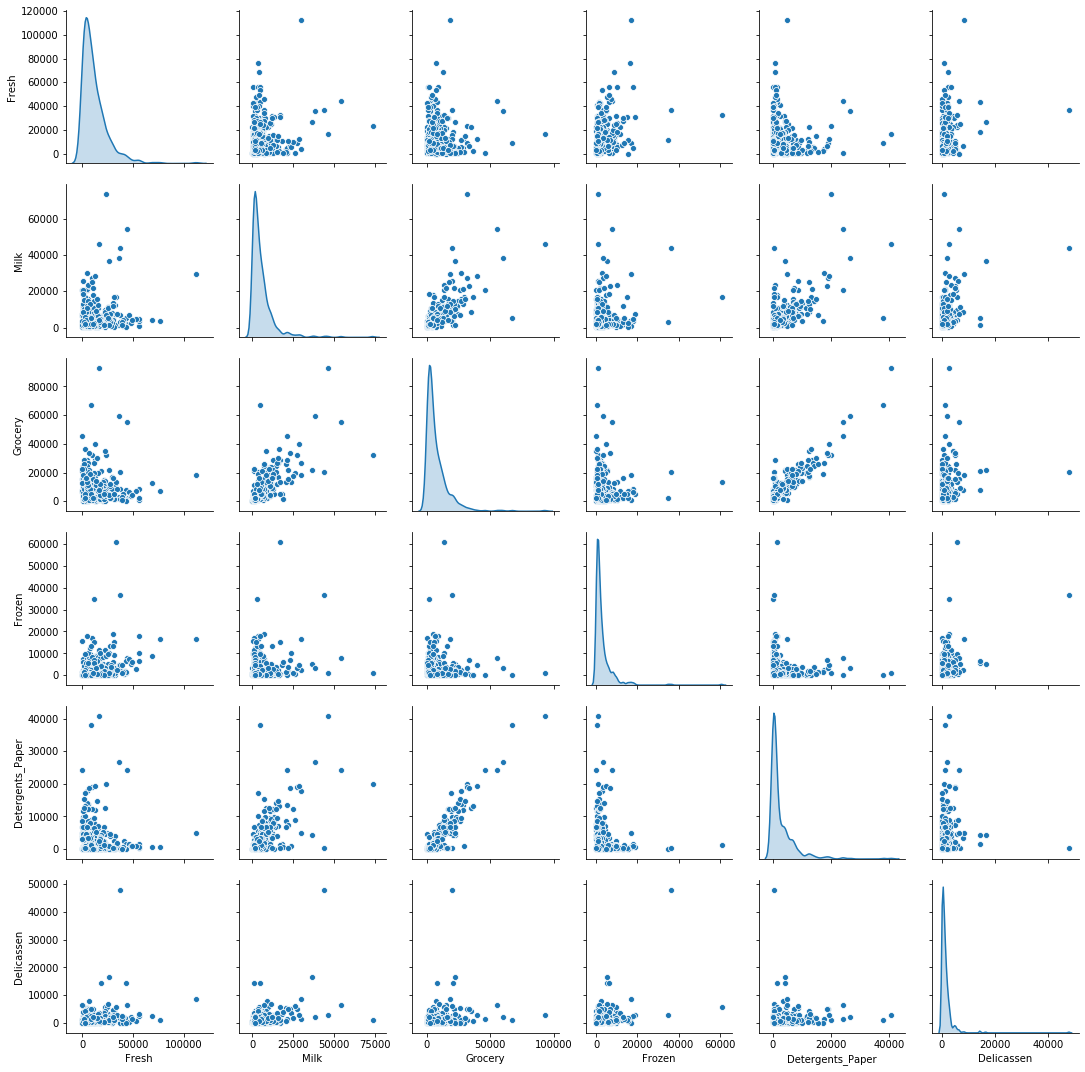

In [49]:
import seaborn as sns
sns.pairplot(wholesale, diag_kind='kde');

Most variables have non-symmetrical distributions i.e. they are skewed

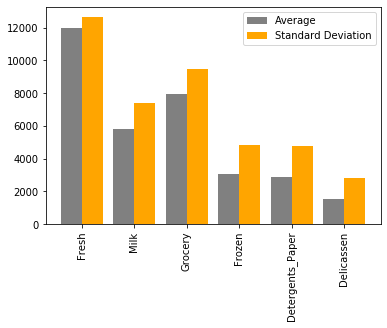

In [50]:
averages = wholesale.mean()
std_devs = wholesale.std()
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

plt.bar(x=x_ix-0.2, height=averages, color='grey', label='Average', width=0.4)
plt.bar(x=x_ix+0.2, height=std_devs, color='orange', label='Standard Deviation', width=0.4)
plt.xticks(ticks=x_ix, labels=x_names, rotation=90)
plt.legend()
plt.show()

___Un-skew___ the variables:

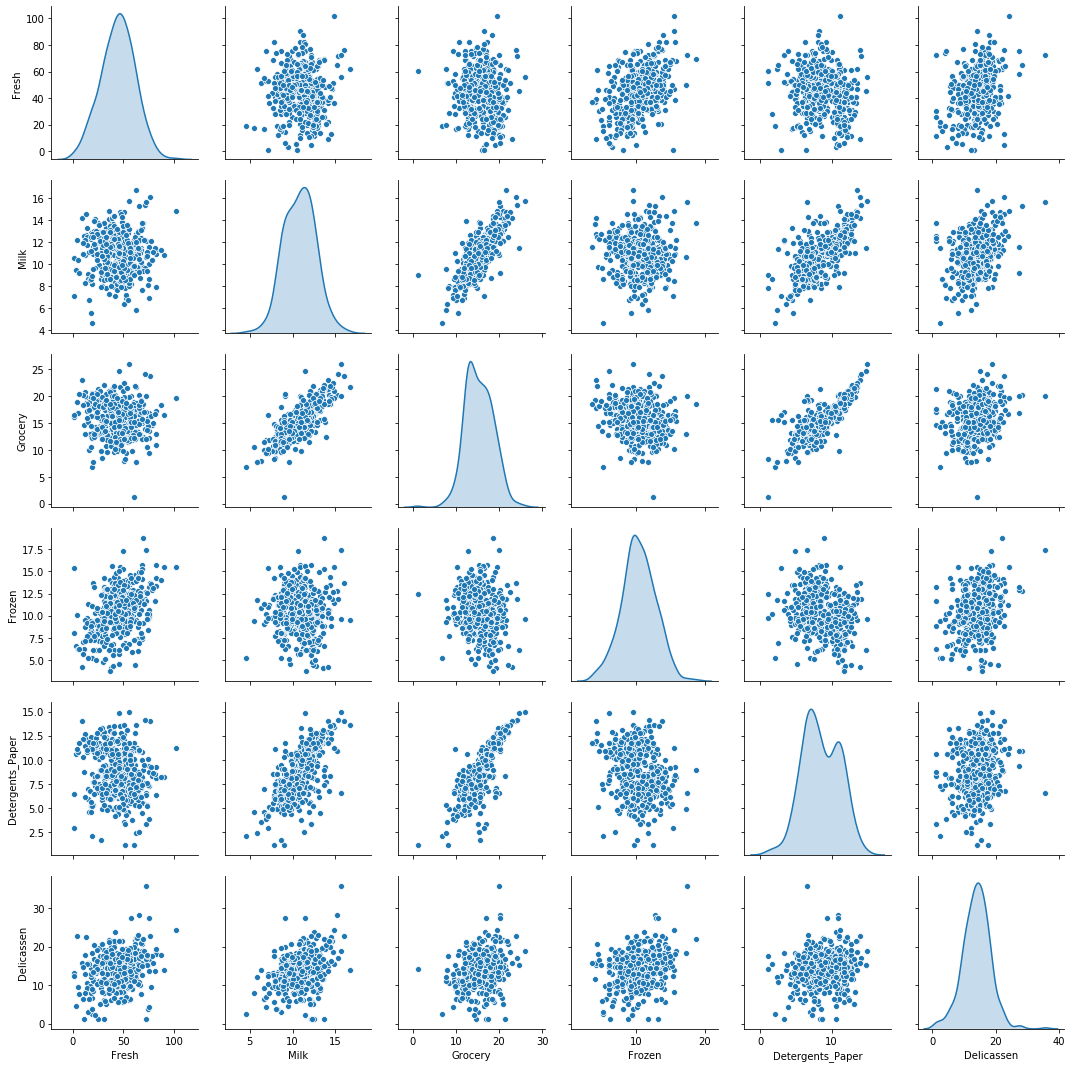

In [51]:
from scipy import stats

def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)
sns.pairplot(wholesale_boxcox, diag_kind='kde');

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(wholesale_boxcox)
wholesale_scaled = scaler.transform(wholesale_boxcox)

wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled,
                                       index=wholesale_boxcox.index,
                                       columns=wholesale_boxcox.columns)

print(wholesale_scaled_df.agg(['mean','std']).round())

      Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
mean   -0.0   0.0     -0.0    -0.0              -0.0         0.0
std     1.0   1.0      1.0     1.0               1.0         1.0


### Customer segmentation using KMeans

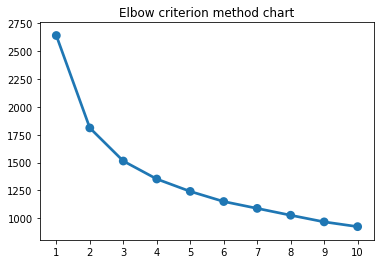

In [53]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('Elbow criterion method chart');

The "elbow" is somewhere around 2 or 3 clusters, which means we should start cluster with +1 number of clusters i.e. with 3 or 4.

In [54]:
k=4
kmeans = KMeans(n_clusters=k)
kmeans.fit(wholesale_scaled_df)
wholesale_kmeans = wholesale.assign(segment = kmeans.labels_)
wholesale_kmeans.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,segment
index,,,,,,,
0,12669,9656,7561,214,2674,1338,2
1,7057,9810,9568,1762,3293,1776,2
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,1
4,22615,5410,7198,3915,1777,5185,1


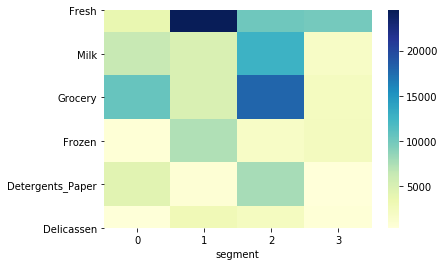

In [55]:
kmeans_averages = wholesale_kmeans.groupby('segment').mean().round()
sns.heatmap(kmeans_averages.T, cmap='YlGnBu');

### Customer segmentation using NMF

Non-negative matrix factorisation

In [56]:
from sklearn.decomposition import NMF
nmf = NMF(k)
nmf.fit(wholesale)
components = pd.DataFrame(nmf.components_, columns=wholesale.columns)

segment_weights = pd.DataFrame(nmf.transform(wholesale), columns=components.index)
segment_weights.index = wholesale.index
wholesale_nmf = wholesale.assign(segment=segment_weights.idxmax(axis=1))
wholesale_nmf.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,segment
index,,,,,,,
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,0


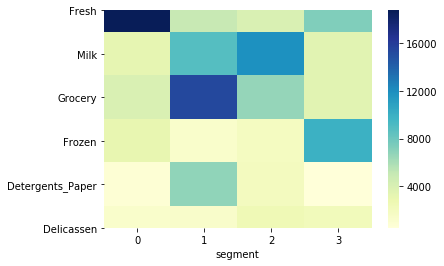

In [57]:
nmf_averages = wholesale_nmf.groupby('segment').mean().round()
sns.heatmap(nmf_averages.T, cmap='YlGnBu');